# LSTM Stock Predictor Using Fear and Greed Index

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin fear and greed index values to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [28]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [29]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [30]:
# Load the fear and greed sentiment data for Bitcoin
sentiment_path = 'BTC_Sentiment.csv'
df = pd.read_csv(sentiment_path, index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [31]:
# Load the historical closing prices for Bitcoin
historic_path = 'BTC_Historic.csv'
df2 = pd.read_csv(historic_path, index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [32]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [33]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [34]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [35]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size_1 = 10
window_size_2 = 5

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size_1, feature_column, target_column)

In [36]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [38]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [40]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [41]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [42]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 30)            3840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [43]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
372/372 [==============================] - 10s 9ms/step - loss: 0.0667
Epoch 2/10
372/372 [==============================] - 3s 9ms/step - loss: 0.0717
Epoch 3/10
372/372 [==============================] - 3s 9ms/step - loss: 0.0743
Epoch 4/10
372/372 [==============================] - 4s 11ms/step - loss: 0.0777
Epoch 5/10
372/372 [==============================] - 4s 10ms/step - loss: 0.0724
Epoch 6/10
372/372 [==============================] - 4s 11ms/step - loss: 0.0735
Epoch 7/10
372/372 [==============================] - 3s 9ms/step - loss: 0.0708
Epoch 8/10
372/372 [==============================] - 3s 9ms/step - loss: 0.0682
Epoch 9/10
372/372 [==============================] - 3s 9ms/step - loss: 0.0642
Epoch 10/10
372/372 [==============================] - 4s 11ms/step - loss: 0.0712


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [44]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 3s 9ms/step - loss: 0.1219


0.12194047123193741

In [45]:
# Make some predictions
predicted = model.predict(X_test)

In [46]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [47]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,4717.979980
2019-02-21,3974.050049,4793.755371
2019-02-22,3937.040039,4861.982910
2019-02-23,3983.530029,4912.349121
2019-02-24,4149.089844,4949.642578


<AxesSubplot:>

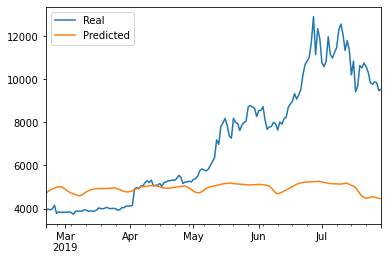

In [48]:
# Plot the real vs predicted values as a line chart
stocks.plot()

### Comparing this model, which uses a 10 day window of Bitcoin fear and greed index valuess, to the other model, which uses a 10 day window of Bitcoin closing prices, the Closing Prices model appears to be better:
- Closing Prices Loss: 0.0616.  Fear & Greed Loss: 0.1219.
- Tracking Values over Time: The model based on closing prices appears to track the actual values better over time than does the model based on the Fear & Greed Index.  Comparing the charts for the two models of Real vs. Predicted values over time, the predictions based on Closing Prices more closely reflect the true values than do the predictions based on the Fear & Greed Index.
- Which window size works best for this specific model:

### Which window size works best for this specific model?

#### To do this, pre-process data again using new "window_size" variable, then re-run model and compare results.

In [49]:
# First model used window_size_1 (10 day window); this model will use window_size_2 (5 day window):
X, y = window_data(df, window_size_2, feature_column, target_column)

# Use 70% of the data for training and the remainder for testing:
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build model:
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [50]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)


Epoch 1/10
375/375 [==============================] - 13s 11ms/step - loss: 0.0756 0s - 
Epoch 2/10
375/375 [==============================] - 5s 13ms/step - loss: 0.0656
Epoch 3/10
375/375 [==============================] - 6s 16ms/step - loss: 0.0735
Epoch 4/10
375/375 [==============================] - 8s 22ms/step - loss: 0.0752: 2s - - ETA: 1s - lo - ETA: 1s - loss: 0 - ETA: 1s - lo - ETA: 0s - l
Epoch 5/10
375/375 [==============================] - 7s 19ms/step - loss: 0.0758: 0s - lo
Epoch 6/10
375/375 [==============================] - 8s 21ms/step - loss: 0.0685
Epoch 7/10
375/375 [==============================] - 7s 20ms/step - loss: 0.0688
Epoch 8/10
375/375 [==============================] - 5s 14ms/step - loss: 0.0678: 5s - loss: 0.17 - ET
Epoch 9/10
375/375 [==============================] - 5s 15ms/step - loss: 0.0678
Epoch 10/10
375/375 [==============================] - 4s 12ms/step - loss: 0.0634


In [51]:
# Evaluate the model
model.evaluate(X_test, y_test)

6/6 [==============================] - 2s 4ms/step - loss: 0.1180


0.1180158331990242

In [52]:
# Make some predictions
predicted = model.predict(X_test)

# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [53]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 

<AxesSubplot:>

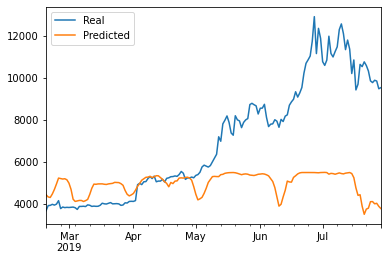

In [54]:
# Plot the real vs predicted values as a line chart
stocks.plot()

### Comparing the first model, which uses a 10 day window of Bitcoin Fear and Greed Index values, to the 2nd model, which uses a 5 day window of Bitcoin Fear and Greed Index values, the 5 day window appears to be a better model:
- 5-Day F&G Loss: 0.1180.  10-Day F&G Loss: 0.1219.
- Tracking Values over Time: The model based on the 5-day window of Bitcoin Fear and Greed Index values appears to track the actual values better over time than does the model based on the 10-day window of Bitcoin Fear and Greed Index values.  Comparing the charts for the two models of Real vs. Predicted values over time, the predictions based on the 5-day window more closely reflect the true values than do the predictions based on the 10-day window, similar to the models based on Bitcoin closing prices.